## Algoritmo Genético

No jupyter anterior utilizamos o algoritmo Gradiente Decrescente para otimizar a função objetivo, afim de comparações, dessa vez utilizaremos um algoritmo genético.

In [1]:
from random import randint, uniform, random
from tqdm import tqdm
import numpy as np

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

In [3]:
# Parâmetros iniciais

tamanhoPopulacao = 30
taxaMutacao = 0.01
taxaCrossover = 0.85
numeroGeracoes = 70
quantidadeVariaveis = 3 # Para o sistema dinâmico avaliado, apenas os controles devem ser avaliados
quantidadeTrocas = 2 # Posicoes a serem trocadas na 

In [4]:
def gerarPopulacao(xMin, xMax):
    populacao = np.zeros((tamanhoPopulacao,quantidadeVariaveis))
    for individuo in range(tamanhoPopulacao):
        for pos in range(quantidadeVariaveis):
            populacao[individuo,pos] = uniform(xMin, xMax)
    return populacao

In [5]:
def divisaoFitness(valorFuncaoObjetivo):
    divisao = 0
    for i in range(len(valorFuncaoObjetivo)):
        divisao += valorFuncaoObjetivo[i]
    return divisao

def fitness(valorFuncaoObjetivo):
    return valorFuncaoObjetivo/divisaoFitness(valorFuncaoObjetivo)

In [6]:
def calcularFuncao(populacao, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise):
    valorFuncaoObj = np.zeros(tamanhoPopulacao)
    for individuo in range(tamanhoPopulacao):
        valorFuncaoObj[individuo] = funcaoObjetivo(populacao[individuo,:], iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    return valorFuncaoObj

In [7]:
def selecao(valorFitness):
    pos = np.random.choice(range(tamanhoPopulacao), 2, replace=False)
    valor = valorFitness[pos[0]] < valorFitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [8]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [9]:
def mutacao(individuo):
    pos = np.random.choice(range(quantidadeVariaveis),  quantidadeTrocas ,replace=False)
    individuo[pos[0]] = individuo[pos[1]]
    individuo[pos[1]] = individuo[pos[0]]
    return individuo

In [10]:
import matplotlib.pyplot as plt

In [11]:
def main(xMin, xMax, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise):
    pop = gerarPopulacao(xMin, xMax)
    fo = calcularFuncao(pop, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    fit = fitness(fo)
    melhor_fo = np.zeros(numeroGeracoes)
    melhor_ind_geracao = np.zeros((numeroGeracoes, quantidadeVariaveis))
    for geracao in range(numeroGeracoes):
        new_pop = np.empty((0, quantidadeVariaveis))
        for i in range(round((tamanhoPopulacao) / 2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < taxaCrossover:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :]) 
                if random() < taxaMutacao:    
                    filho1 = mutacao(filho1)
                    filho2 = mutacao(filho2)  
                new_pop = np.vstack([new_pop, filho1, filho2])     
            else:
                pais = np.vstack([pop[pai1, :], pop[pai2, :]])
                new_pop = np.vstack([new_pop, pais])
        pop = new_pop    
        fo = calcularFuncao(pop, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)

    
    #plt.plot(melhor_fo)
    #plt.xlim(0, numeroGeracoes)
    #plt.ylabel('Gerações')
    #plt.ylabel('Melhor Custo')
    #plt.title('Evolução da função objetivo - GA')
    #plt.grid(True)
    #plt.show()
    

    return pop[pos_min_fo,:][0,0]

In [12]:
# Função de origem e destino
ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

hamiltoniano = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
hamiltoniano = [[A, 0], [0, B]]

iteracao = 0
fatorRungeKutta = 0.01
tempoAnalise = 2000
horizonte = 3

xMin = -10
xMax = 10

constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1

minimo = main(xMin, xMax, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

In [13]:
minimo

array([-0.10691641,  0.85358147, -2.79999658])

In [15]:
while iteracao < 2000:
    
    print(f"Iteração: {iteracao}")
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, minimo[0]],[minimo[0],0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]

    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)

    print(ondaOrigem[0][0])
    print(ondaOrigem[1][0])
    print("--------------")
    
    ## Adaptação da onda ao controle
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(minimo, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)

    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]

    xMax = -minimo[0]
    xMin = minimo[0]
    
    iteracao += 1

    minimo = main(xMax, xMin, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

Iteração: 0
(0.8+0j)
(0.6+0j)
--------------
Iteração: 1
(0.7999397759024777-0.011283495915108537j)
(0.5993862851695653-0.026554072260023126j)
--------------
Iteração: 2
(0.7997235401948525-0.023050603604104523j)
(0.5975179542287403-0.053695653555901696j)
--------------
Iteração: 3
(0.7993147462377209-0.035180630604804065j)
(0.5943597307824194-0.08120818896246546j)
--------------
Iteração: 4
(0.7986989791230488-0.04752112953282341j)
(0.5898958728804513-0.108832632763481j)
--------------
Iteração: 5
(0.7978597075797073-0.06003447550137089j)
(0.5841175407416673-0.136464087273033j)
--------------
Iteração: 6
(0.7967850738301111-0.07268366069990681j)
(0.5770224919491852-0.16399900933534095j)
--------------
Iteração: 7
(0.7954683717870891-0.0854307699890834j)
(0.5686153264794381-0.1913328595687362j)
--------------
Iteração: 8
(0.7939106281916416-0.09823113320928299j)
(0.5589089184576852-0.21835150413115245j)
--------------
Iteração: 9
(0.7921108106881943-0.11106066632708116j)
(0.54791968260

Iteração: 75
(0.28933044562498694-0.7117475840872542j)
(-0.5881156023105008+0.2526327447071421j)
--------------
Iteração: 76
(0.278375925854363-0.7156456368158742j)
(-0.5762556204439703+0.2797992527819766j)
--------------
Iteração: 77
(0.2673873233804653-0.7193833776598821j)
(-0.5631325133576859+0.3063875701160557j)
--------------
Iteração: 78
(0.25636656578388073-0.7229614893769218j)
(-0.5487747650374287+0.33233886547447045j)
--------------
Iteração: 79
(0.24531551391945766-0.7263806557222138j)
(-0.5332135998800019+0.35759571290390957j)
--------------
Iteração: 80
(0.23423596334435504-0.7296415578052464j)
(-0.5164829134508999+0.38210221932720867j)
--------------
Iteração: 81
(0.22312964592385565-0.7327448705398519j)
(-0.4986191973048924+0.40580414873294957j)
--------------
Iteração: 82
(0.21199823160999753-0.73569125919606j)
(-0.4796614580366053+0.4286490426840491j)
--------------
Iteração: 83
(0.2008433303876853-0.7384813760618749j)
(-0.4596511307410075+0.45058633687745825j)
--------

Iteração: 148
(-0.5126917598570597-0.5887807074429481j)
(0.5006310493864133-0.37396922543115685j)
--------------
Iteração: 149
(-0.5222515144410053-0.5811253317267283j)
(0.48190751206833493-0.3966255734366332j)
--------------
Iteração: 150
(-0.5317110800217798-0.5733020395350185j)
(0.4621451665427384-0.41836579094266896j)
--------------
Iteração: 151
(-0.541066918305177-0.5653114532309768j)
(0.4413884807238787-0.43914206235489667j)
--------------
Iteração: 152
(-0.5503154565339152-0.5571542949238689j)
(0.41968412485645473-0.4589087232939009j)
--------------
Iteração: 153
(-0.5594530911957808-0.5488313890526856j)
(0.39708086763661954-0.4776223619801859j)
--------------
Iteração: 154
(-0.5684761918663318-0.5403436648081457j)
(0.3736294676700988-0.4952419156095306j)
--------------
Iteração: 155
(-0.5773811051786473-0.5316921583866564j)
(0.3493825605087406-0.5117287615045177j)
--------------
Iteração: 156
(-0.5861641589123033-0.5228780150701566j)
(0.32439454151664837-0.527046802839637j)
--

Iteração: 220
(-0.7583492551553639+0.24548323681981774j)
(-0.3479213960021032+0.49355351972563777j)
--------------
Iteração: 221
(-0.7539139050619637+0.25768440283826305j)
(-0.32402624070223035+0.5101171968762885j)
--------------
Iteração: 222
(-0.7492722371983803+0.2697908907799743j)
(-0.2993657580445827+0.5255322250740613j)
--------------
Iteração: 223
(-0.7444268929600153+0.28179876979847496j)
(-0.27399500411341027+0.5397636324396647j)
--------------
Iteração: 224
(-0.7393806071528822+0.29370420507185385j)
(-0.24797062495225652+0.5527790820900552j)
--------------
Iteração: 225
(-0.7341362038895096+0.30550346070871753j)
(-0.2213507305776494+0.5645489441963514j)
--------------
Iteração: 226
(-0.7286965923741632+0.31719290246587883j)
(-0.19419476573564687+0.5750463620229189j)
--------------
Iteração: 227
(-0.7230647625862495+0.328769000273113j)
(-0.16656337768856522+0.584247311800776j)
--------------
Iteração: 228
(-0.7172437808709693+0.34022833056073476j)
(-0.13851828132581945+0.59213

Iteração: 293
(-0.09299933667864209+0.7573060111288324j)
(0.2089847738487747-0.6116895256839516j)
--------------
Iteração: 294
(-0.08168764862173779+0.7584903588827876j)
(0.18066987743241084-0.6207881132240427j)
--------------
Iteração: 295
(-0.07036665921634305+0.7595244117839148j)
(0.15195862298878204-0.6285537054239406j)
--------------
Iteração: 296
(-0.05903743536122204+0.7604083835142796j)
(0.1229140984243046-0.6349691160868216j)
--------------
Iteração: 297
(-0.04770102583339917+0.7611424432464324j)
(0.09360013139904402-0.6400201489283989j)
--------------
Iteração: 298
(-0.03635846488965676+0.76172671474271j)
(0.06408114761765438-0.6436956291196106j)
--------------
Iteração: 299
(-0.025010775907807346+0.7621612756485657j)
(0.034422027791076545-0.6459874281153759j)
--------------
Iteração: 300
(-0.01365897505818581+0.7624461569816049j)
(0.00468796358692896-0.6468904817142253j)
--------------
Iteração: 301
(-0.002304074995737773+0.7625813428175453j)
(-0.02505568711122723-0.64640280

Iteração: 366
(0.6641795926682527+0.43005790891866197j)
(-0.04298087447003657+0.6099740046909461j)
--------------
Iteração: 367
(0.6714407898513332+0.4195951012902566j)
(-0.01380560590852014+0.6106689775913782j)
--------------
Iteração: 368
(0.6785365317875778+0.4089914335896752j)
(0.015359708678281795+0.6099821635259635j)
--------------
Iteração: 369
(0.6854632967817397+0.3982495734918442j)
(0.044449858720229746+0.6079157294967449j)
--------------
Iteração: 370
(0.6922176095348131+0.3873723063565036j)
(0.07339981082314578+0.604474915245289j)
--------------
Iteração: 371
(0.6987960459389142+0.376362534221402j)
(0.10214485342970551+0.5996680214457942j)
--------------
Iteração: 372
(0.7051952378400128+0.36522327458142445j)
(0.13062074076237676+0.5935063910922692j)
--------------
Iteração: 373
(0.7114118777586311+0.3539576589550817j)
(0.1587638357283941+0.5860043841211962j)
--------------
Iteração: 374
(0.717442723558692+0.34256893124025045j)
(0.18651125146906647+0.5771793453261349j)
----

Iteração: 439
(0.6441395130320623-0.4538569154488788j)
(-0.18261240016707553-0.5880058446371177j)
--------------
Iteração: 440
(0.6363704547708801-0.46372486198311014j)
(-0.21056476530917706-0.5793568418483285j)
--------------
Iteração: 441
(0.6284565297558118-0.47344291339805933j)
(-0.2380879260008516-0.5693929322588823j)
--------------
Iteração: 442
(0.6204013629732849-0.48300926566549973j)
(-0.2651202696900571-0.558135659580659j)
--------------
Iteração: 443
(0.6122085846980905-0.4924222305690376j)
(-0.29160126547162174-0.5456094494903931j)
--------------
Iteração: 444
(0.6038818259324988-0.5016802346445934j)
(-0.317471598756688-0.5318415554780594j)
--------------
Iteração: 445
(0.5954247139187748-0.5107818179213954j)
(-0.3426733032405468-0.5168619984072441j)
--------------
Iteração: 446
(0.5868408677341893-0.519725632467454j)
(-0.3671498898754672-0.500703499921825j)
--------------
Iteração: 447
(0.5781338939774187-0.5285104407439041j)
(-0.3908464725617836-0.4834014098469633j)
-----

Iteração: 512
(-0.1178661725127595-0.7549663930058258j)
(0.33741374221522563+0.5498047353453687j)
--------------
Iteração: 513
(-0.12919109024592104-0.7533629314644522j)
(0.3622152731160216+0.5334360516438098j)
--------------
Iteração: 514
(-0.1405059243781042-0.7516051605961229j)
(0.3862200753034613+0.5159280867801241j)
--------------
Iteração: 515
(-0.15180932481919826-0.7496924565936095j)
(0.4093755143606562+0.49731962270072544j)
--------------
Iteração: 516
(-0.16309989292875268-0.747624167446292j)
(0.4316308417645727+0.47765187638250306j)
--------------
Iteração: 517
(-0.17437617879234676-0.7453996155950489j)
(0.45293730752285427+0.45696840824319307j)
--------------
Iteração: 518
(-0.18563667863155872-0.7430181007352401j)
(0.47324826836845196+0.4353150253450078j)
--------------
Iteração: 519
(-0.19687983235472056-0.7404789027612343j)
(0.4925192912715878+0.4127396796066953j)
--------------
Iteração: 520
(-0.20810402125532762-0.737781284845592j)
(0.5107082520389835+0.389292361250295

Iteração: 585
(-0.7695648620873785-0.2145726871339871j)
(-0.4512177639101757-0.39765686188736654j)
--------------
Iteração: 586
(-0.7732090163516269-0.2020120067036103j)
(-0.4696320887390352-0.3752127831577702j)
--------------
Iteração: 587
(-0.7766332657853855-0.18937859714948646j)
(-0.48695650264504065-0.3519230698999064j)
--------------
Iteração: 588
(-0.7798357142954523-0.17667699619389532j)
(-0.5031523178960636-0.32784021693570936j)
--------------
Iteração: 589
(-0.7828145889946219-0.1639118064283476j)
(-0.5181833669947226-0.30301848491569955j)
--------------
Iteração: 590
(-0.785568242828707-0.15108769089121182j)
(-0.5320160831200326-0.2775137795180626j)
--------------
Iteração: 591
(-0.7880951570150687-0.13820936853085525j)
(-0.544619574784881-0.2513835269901743j)
--------------
Iteração: 592
(-0.7903939432875348-0.12528160956295137j)
(-0.5559656945433541-0.22468654630929072j)
--------------
Iteração: 593
(-0.7924633459429937-0.11230923073083772j)
(-0.5660291015951686-0.19748291

Iteração: 657
(-0.48854339792090185+0.6043421449098407j)
(0.5759373114121447+0.25375597446538184j)
--------------
Iteração: 658
(-0.4787634982396624+0.6113790009152793j)
(0.5878476695460817+0.22679574150066178j)
--------------
Iteração: 659
(-0.4689005887133272+0.6182507215766297j)
(0.5984812768692457+0.19929476990692313j)
--------------
Iteração: 660
(-0.4589577552881266+0.624957268694433j)
(0.6078139176073849+0.17131372849614707j)
--------------
Iteração: 661
(-0.4489380250027285+0.6314986740181665j)
(0.615824260827833+0.14291436239229463j)
--------------
Iteração: 662
(-0.43884436394814563+0.6378750355031231j)
(0.6224939080023979+0.11415935588256035j)
--------------
Iteração: 663
(-0.4286796754201325+0.6440865134940801j)
(0.6278074340531745+0.08511219317857313j)
--------------
Iteração: 664
(-0.41844679826701264+0.6501333268451244j)
(0.6317524217900015+0.055837017397049674j)
--------------
Iteração: 665
(-0.40814850543542847+0.6560157489851274j)
(0.6343194896629681+0.026398488073363

Iteração: 730
(0.31472010932858135+0.7040157358908964j)
(-0.6260751781242397-0.11551157700215572j)
--------------
Iteração: 731
(0.3256470859072421+0.6995912355533278j)
(-0.6301531176401096-0.08621533232983342j)
--------------
Iteração: 732
(0.33653153302644456+0.6949986885814474j)
(-0.6328510757314934-0.05676990979577769j)
--------------
Iteração: 733
(0.3473709182338801+0.6902374510807283j)
(-0.6341637182093467-0.027240435058971734j)
--------------
Iteração: 734
(0.3581626364330104+0.6853069158501698j)
(-0.634088785189266+0.0023077897317192522j)
--------------
Iteração: 735
(0.3689040103915398+0.6802065164831168j)
(-0.6326270959534954+0.03180943102188677j)
--------------
Iteração: 736
(0.3795922914540266+0.6749357314598763j)
(-0.6297825469691973+0.061199269003207116j)
--------------
Iteração: 737
(0.39022466045833665+0.6694940882223349j)
(-0.625562103067431+0.09041234250970388j)
--------------
Iteração: 738
(0.40079822885517863+0.6638811672208055j)
(-0.6199757818024874+0.119384093336

Iteração: 803
(0.8004275675487666-0.01428721781759634j)
(0.592100614447738-0.0923493325963499j)
--------------
Iteração: 804
(0.7999972415092305-0.02742510479673184j)
(0.5870548247334637-0.1209084870786224j)
--------------
Iteração: 805
(0.7993332727501541-0.04054888528591426j)
(0.5806566869166123-0.1491974233764632j)
--------------
Iteração: 806
(0.7984362127653245-0.05365359768971856j)
(0.5729204525581526-0.17715251284590228j)
--------------
Iteração: 807
(0.7973067517242322-0.0667343053311501j)
(0.5638633594686038-0.20471086952926834j)
--------------
Iteração: 808
(0.7959457172583445-0.07978610147854409j)
(0.5535055933780618-0.2318104901346506j)
--------------
Iteração: 809
(0.7943540730350022-0.09280411431165206j)
(0.54187024305006-0.2583903920529926j)
--------------
Iteração: 810
(0.7925329171220052-0.10578351181733611j)
(0.5289832489390499-0.2843907491059569j)
--------------
Iteração: 811
(0.7904834801464018-0.1187195066054465j)
(0.5148733455056425-0.3097530247227453j)
----------

Iteração: 876
(0.2955535447990432-0.7080597514780744j)
(-0.5705403343072712+0.2928876327710377j)
--------------
Iteração: 877
(0.28469439354845394-0.7120741425736472j)
(-0.5568002459306887+0.31917542486905426j)
--------------
Iteração: 878
(0.27379841780131464-0.715931488360916j)
(-0.5418406283918823+0.3447973487369497j)
--------------
Iteração: 879
(0.26286741109880046-0.7196323835141588j)
(-0.5256940504941399+0.3696967269058719j)
--------------
Iteração: 880
(0.251903103853026-0.7231774177443012j)
(-0.5083957153701505+0.3938184773441439j)
--------------
Iteração: 881
(0.2409071650480935-0.7265671723206928j)
(-0.48998338239431055+0.41710923583985887j)
--------------
Iteração: 882
(0.22988120411099378-0.7298022166988924j)
(-0.47049728341344804+0.4395174745673836j)
--------------
Iteração: 883
(0.2188267729468285-0.7328831052624717j)
(-0.4499800334821469+0.46099361657420856j)
--------------
Iteração: 884
(0.20774536813245054-0.7358103741865686j)
(-0.42847653630106586+0.4814901459336528j

Iteração: 949
(-0.508995043282325-0.5939566211438531j)
(0.47159584995496856-0.4071079415702496j)
--------------
Iteração: 950
(-0.518667572651601-0.5863297215680356j)
(0.4513384185528563-0.4283631429469067j)
--------------
Iteração: 951
(-0.5282389513537057-0.5785316966296745j)
(0.4301098614894756-0.4486314042386208j)
--------------
Iteração: 952
(-0.5377055247044277-0.5705632514798475j)
(0.4079579101579663-0.4678681777972252j)
--------------
Iteração: 953
(-0.5470636081153374-0.5624251958758726j)
(0.38493234063304266-0.48603121740052746j)
--------------
Iteração: 954
(-0.5563094910175126-0.5541184465364369j)
(0.3610848628866417-0.5030806720396437j)
--------------
Iteração: 955
(-0.5654394409086886-0.5456440293253387j)
(0.3364690057064722-0.5189791743796708j)
--------------
Iteração: 956
(-0.5744497075158691-0.5370030812579479j)
(0.31113999757332583-0.5336919236970774j)
--------------
Iteração: 957
(-0.5833365270651616-0.5281968523248726j)
(0.2851546437619947-0.5471867631094731j)
-----

Iteração: 1021
(-0.7590353690792181+0.24032813760618443j)
(-0.3115532255199073+0.5186928010130408j)
--------------
Iteração: 1022
(-0.7546578105383251+0.25250495467951406j)
(-0.28651917941426014+0.5335162003325268j)
--------------
Iteração: 1023
(-0.7500760189713075+0.264586960911512j)
(-0.26080307075618003+0.5471392907095756j)
--------------
Iteração: 1024
(-0.7452926848043359+0.27657033992176744j)
(-0.2344622967394913+0.5595310819563085j)
--------------
Iteração: 1025
(-0.7403105861670274+0.2884513742432546j)
(-0.20755565424237252+0.570663324784122j)
--------------
Iteração: 1026
(-0.7351325846475049+0.300226447951943j)
(-0.18014320906104306+0.5805105737752335j)
--------------
Iteração: 1027
(-0.729761620950023+0.3118920491016389j)
(-0.15228616231990963+0.589050244120193j)
--------------
Iteração: 1028
(-0.7242007104643188+0.32344477196002475j)
(-0.12404671435516222+0.5962626619951874j)
--------------
Iteração: 1029
(-0.7184529387560193+0.33488131904229285j)
(-0.09548792637442628+0.6

Iteração: 1093
(-0.11168861082094575+0.754603731174969j)
(0.19561739900420408-0.6163056315107031j)
--------------
Iteração: 1094
(-0.10042109260374919+0.7560949772436614j)
(0.16709786435595625-0.6247513331964285j)
--------------
Iteração: 1095
(-0.08913881243873452+0.7574367614587891j)
(0.13821325079405905-0.6318550916224525j)
--------------
Iteração: 1096
(-0.07784281715053475+0.7586291812515595j)
(0.10902703362785082-0.637601209257793j)
--------------
Iteração: 1097
(-0.06653413871505688+0.7596722889149076j)
(0.0796033572518409-0.6419769950956841j)
--------------
Iteração: 1098
(-0.055213797884301294+0.7605660908228054j)
(0.050006892732109336-0.6449727928457063j)
--------------
Iteração: 1099
(-0.04388280784582177+0.7613105468445285j)
(0.02030269422219719-0.6465820023824982j)
--------------
Iteração: 1100
(-0.03254217790723372+0.7619055699553219j)
(-0.009443945472365826-0.6468010944033722j)
--------------
Iteração: 1101
(-0.021192917196120542+0.7623510260444483j)
(-0.0391676398598565

Iteração: 1165
(0.6470817479430849+0.4558233672120004j)
(-0.05713195619795368+0.6084785450620953j)
--------------
Iteração: 1166
(0.6547487569581496+0.4456395955580575j)
(-0.027986101279675626+0.6098574628926107j)
--------------
Iteração: 1167
(0.662255302555615+0.43530856269105617j)
(0.0011823068294166302+0.6098548207188362j)
--------------
Iteração: 1168
(0.6695977611126085+0.4248328273757922j)
(0.030308025836444322+0.6084712493832234j)
--------------
Iteração: 1169
(0.6767725522268608+0.41421506775336714j)
(0.059325918194982556+0.6057104557695313j)
--------------
Iteração: 1170
(0.6837761435439174+0.4034580804536673j)
(0.08817109600365104+0.6015792144071699j)
--------------
Iteração: 1171
(0.6906050555573471+0.3925647794929212j)
(0.11677906534729238+0.596087352254591j)
--------------
Iteração: 1172
(0.6972558663720293+0.3815381949575282j)
(0.1450858697598404+0.5892477266955951j)
--------------
Iteração: 1173
(0.7037252164206592+0.3703814714758169j)
(0.17302823248993382+0.58107619679

Iteração: 1238
(0.6611703889878114-0.4281478513630688j)
(-0.16890814905154286-0.5924635835079616j)
--------------
Iteração: 1239
(0.653798336854979-0.43829954597857834j)
(-0.197061492634467-0.5844723580137192j)
--------------
Iteração: 1240
(0.6462762848655277-0.44830733289911434j)
(-0.22481667921627363-0.5751564013525823j)
--------------
Iteração: 1241
(0.6386077749901554-0.45816929714218974j)
(-0.25211160458070414-0.5645358004910538j)
--------------
Iteração: 1242
(0.6307963576282242-0.46788363876421984j)
(-0.27888517797302714-0.5526335490623372j)
--------------
Iteração: 1243
(0.6228455870327889-0.4774486719153056j)
(-0.3050774580081749-0.5394754964023025j)
--------------
Iteração: 1244
(0.6147590168042035-0.4868628236930048j)
(-0.3306297860261596-0.5250902902355307j)
--------------
Iteração: 1245
(0.6065401954614863-0.49612463279884284j)
(-0.355484916598292-0.5095093131388094j)
--------------
Iteração: 1246
(0.5981926621004372-0.5052327480017387j)
(-0.3795871448940553-0.49276661292

Iteração: 1310
(-0.07648725008477882-0.7601556337097537j)
(0.2980987625128679+0.5722326127760351j)
--------------
Iteração: 1311
(-0.08787602507276991-0.7591643191494809j)
(0.32399420726790773+0.557651339608846j)
--------------
Iteração: 1312
(-0.09926263645945067-0.7580187233769853j)
(0.3491753197016642+0.5418773498014623j)
--------------
Iteração: 1313
(-0.11064578753883085-0.756718175868919j)
(0.3735868569465698+0.5249456108688481j)
--------------
Iteração: 1314
(-0.12202413590662915-0.7552619744398291j)
(0.39717528528815055+0.5068936525174789j)
--------------
Iteração: 1315
(-0.13339629055422592-0.7536493876864134j)
(0.4198888989916522+0.4877614832427562j)
--------------
Iteração: 1316
(-0.14476080908523634-0.751879657588966j)
(0.4416779350654605+0.4675915014188266j)
--------------
Iteração: 1317
(-0.15611619506233648-0.7499520022639902j)
(0.46249468370623653+0.4464284010784476j)
--------------
Iteração: 1318
(-0.16746089549168017-0.747865618861597j)
(0.48229359418028966+0.42431907

Iteração: 1382
(-0.7518576492231052-0.26897401268395993j)
(-0.4009302483516325-0.44901883001347853j)
--------------
Iteração: 1383
(-0.7564094507300183-0.2567315758170026j)
(-0.4218727971515793-0.4289019721725451j)
--------------
Iteração: 1384
(-0.7607483972091545-0.24439960994931775j)
(-0.4418325331360107-0.4078169163836774j)
--------------
Iteração: 1385
(-0.7648722066083352-0.23198244477676244j)
(-0.46076485972260717-0.38581124229943836j)
--------------
Iteração: 1386
(-0.768778712309576-0.21948448678842583j)
(-0.47862747540145767-0.3629345795823288j)
--------------
Iteração: 1387
(-0.7724658662246957-0.20691021517297364j)
(-0.49538046782525247-0.33923849740197126j)
--------------
Iteração: 1388
(-0.775931741717039-0.19426417758965778j)
(-0.5109864025855544-0.3147763896199089j)
--------------
Iteração: 1389
(-0.7791745363432172-0.18155098581198395j)
(-0.5254104064777826-0.2896033559172982j)
--------------
Iteração: 1390
(-0.7821925744091514-0.16877531125230755j)
(-0.538620245069797

Iteração: 1454
(-0.5304417999792916+0.5691290366129644j)
(0.541311051257111+0.31891361835520543j)
--------------
Iteração: 1455
(-0.5211460542416131+0.5768597205749966j)
(0.5562965841608215+0.2935535334225813j)
--------------
Iteração: 1456
(-0.5117548934316386+0.5844297798116656j)
(0.5700780107096143+0.26750651725025526j)
--------------
Iteração: 1457
(-0.5022714770879515+0.5918389152148325j)
(0.5826241518050953+0.24082996691260966j)
--------------
Iteração: 1458
(-0.4926989128690161+0.5990869056146151j)
(0.5939065665550637+0.21358268752563758j)
--------------
Iteração: 1459
(-0.48304025406300305+0.6061736042767605j)
(0.6038996156337533+0.18582476164377373j)
--------------
Iteração: 1460
(-0.4732984972805605+0.6130989353043053j)
(0.6125805184160107+0.1576174158148058j)
--------------
Iteração: 1461
(-0.4634765803345585+0.6198628899524862j)
(0.6199294037583667+0.12902288458948916j)
--------------
Iteração: 1462
(-0.45357738031040407+0.6264655228660404j)
(0.6259293543140768+0.1001042722

Iteração: 1526
(0.2532729557622941+0.7270800082656225j)
(-0.6003851496891732-0.21620604265733043j)
--------------
Iteração: 1527
(0.264472124749168+0.723596140461398j)
(-0.6092109195391973-0.18794968896957964j)
--------------
Iteração: 1528
(0.27564264810036443+0.7199444353154848j)
(-0.6166995235192848-0.159319639616985j)
--------------
Iteração: 1529
(0.2867822123223877+0.7161240652483407j)
(-0.6228350038758665-0.13037926608673214j)
--------------
Iteração: 1530
(0.2978884297322351+0.7121342256793356j)
(-0.6276044065090646-0.10119261894745818j)
--------------
Iteração: 1531
(0.30895883826508036+0.7079741391007401j)
(-0.6309978096015934-0.07182428553295328j)
--------------
Iteração: 1532
(0.3199909014838155+0.7036430591774814j)
(-0.6330083455079258-0.04233924643524972j)
--------------
Iteração: 1533
(0.3309820087917733+0.6991402748629678j)
(-0.6336322158551053-0.012802731126100784j)
--------------
Iteração: 1534
(0.3419294758494917+0.6944651145212309j)
(-0.6328686998216747+0.0167199269

Iteração: 1599
(0.7987153827781135+0.05626375777828613j)
(0.599018634810225+0.008044070864892124j)
--------------
Iteração: 1600
(0.799489852607482+0.04313433306109102j)
(0.5987622932553258-0.020952948645900357j)
--------------
Iteração: 1601
(0.8000300971376015+0.029995493149868685j)
(0.597127629936148-0.04990603735434726j)
--------------
Iteração: 1602
(0.8003360814589908+0.016852243547443232j)
(0.5941182430468754-0.07875009050562205j)
--------------
Iteração: 1603
(0.8004079118431288+0.0037095842526702286j)
(0.5897407984570608-0.10742024526537507j)
--------------
Iteração: 1604
(0.8002458353128844-0.00942749540173588j)
(0.5840050148991228-0.1358520250940183j)
--------------
Iteração: 1605
(0.7998502389934065-0.02255402188536396j)
(0.5769236423663805-0.16398148326233614j)
--------------
Iteração: 1606
(0.7992216492449391-0.03566504257030398j)
(0.5685124337696473-0.1917453451893376j)
--------------
Iteração: 1607
(0.7983607305794934-0.048755630785506585j)
(0.5587901099153909-0.2190811

Iteração: 1672
(0.3550098188615356-0.6813706198101805j)
(-0.609284827643551+0.1961479199207362j)
--------------
Iteração: 1673
(0.3444705805700846-0.6862819964748016j)
(-0.6000348832077399+0.22431023165518355j)
--------------
Iteração: 1674
(0.3338823289577238-0.6910369767188492j)
(-0.5894729939905554+0.2520158272182409j)
--------------
Iteração: 1675
(0.3232470473936164-0.6956360589578472j)
(-0.5776219792796788+0.2792034552403684j)
--------------
Iteração: 1676
(0.31256665290910474-0.7000797488830115j)
(-0.5645075188931264+0.30581300541841194j)
--------------
Iteração: 1677
(0.3018429972764287-0.7043685556996504j)
(-0.5501580962558082+0.33178564206179456j)
--------------
Iteração: 1678
(0.2910778682732108-0.708502988441802j)
(-0.5346049352448328+0.35706393480778076j)
--------------
Iteração: 1679
(0.2802729911285725-0.712483552371929j)
(-0.517881930943912+0.381591986215249j)
--------------
Iteração: 1680
(0.2694300301463362-0.7163107454742808j)
(-0.5000255744607607+0.4053155559533465j

Iteração: 1744
(-0.4447051451152547-0.6409487760989568j)
(0.5489631341290648-0.30010227278232543j)
--------------
Iteração: 1745
(-0.4550231042269383-0.6344035801716922j)
(0.533613260792981-0.3251812669391357j)
--------------
Iteração: 1746
(-0.46526065219010226-0.6276815947750254j)
(0.5171056646812306-0.34949959796361607j)
--------------
Iteração: 1747
(-0.4754142549291472-0.6207830135578005j)
(0.4994776313986586-0.37300365719260203j)
--------------
Iteração: 1748
(-0.4854803313779274-0.6137081231641368j)
(0.4807689301607029-0.39564165528753475j)
--------------
Iteração: 1749
(-0.49545525677247493-0.6064573062954216j)
(0.4610217252423073-0.41736373725038844j)
--------------
Iteração: 1750
(-0.5053353660994343-0.5990310446314971j)
(0.44028048210433973-0.4381220931372745j)
--------------
Iteração: 1751
(-0.5151169576936755-0.5914299216036182j)
(0.4185918684062361-0.45787106422363155j)
--------------
Iteração: 1752
(-0.5247962969782053-0.5836546250120725j)
(0.39600465012495417-0.47656724

Iteração: 1816
(-0.7811332469779558+0.16041127379313136j)
(-0.41414844349549645+0.4388394155210226j)
--------------
Iteração: 1817
(-0.7780819852496196+0.17304624713737676j)
(-0.39283831496770827+0.458608079927112j)
--------------
Iteração: 1818
(-0.7748142574634724+0.1856106200978628j)
(-0.3706085532687487+0.4773476263921982j)
--------------
Iteração: 1819
(-0.7713322176961606+0.19810014731137882j)
(-0.3475087323061362+0.4950156709950774j)
--------------
Iteração: 1820
(-0.7676381257353172+0.2105106667714304j)
(-0.32359037150743003+0.5115722143372118j)
--------------
Iteração: 1821
(-0.7637343434032429+0.2228381032787652j)
(-0.2989068212497763+0.5269797306402378j)
--------------
Iteração: 1822
(-0.7596233307445523+0.23507847172075858j)
(-0.27351314421641987+0.5412032513438756j)
--------------
Iteração: 1823
(-0.7553076420859105+0.24722788017379008j)
(-0.24746599294393937+0.5542104430183552j)
--------------
Iteração: 1824
(-0.75078992197624+0.2592825328231288j)
(-0.22082348383243408+0.

Iteração: 1888
(-0.1860607095262615+0.7402642520188897j)
(0.31850432047681576-0.5620899707983715j)
--------------
Iteração: 1889
(-0.1749607514230263+0.7428055420020346j)
(0.2923906633558969-0.5763126322027414j)
--------------
Iteração: 1890
(-0.16383515028566822+0.745197731132338j)
(0.2656381391452174-0.5893001373152227j)
--------------
Iteração: 1891
(-0.15268504311563208+0.7474410126314852j)
(0.23830549688540406-0.6010237833082565j)
--------------
Iteração: 1892
(-0.141511537889467+0.7495355401430606j)
(0.21045277267923476-0.6114576656004799j)
--------------
Iteração: 1893
(-0.13031571691629315+0.7514814261274039j)
(0.18214115640787698-0.6205787354046708j)
--------------
Iteração: 1894
(-0.11909864027142297+0.753278740439427j)
(0.1534328558828284-0.6283668509299778j)
--------------
Iteração: 1895
(-0.10786134929706823+0.7549275090928405j)
(0.1243909587355094-0.6348048221246204j)
--------------
Iteração: 1896
(-0.09660487016091107+0.7564277132138023j)
(0.09507929235148685-0.639878448

Iteração: 1960
(0.5952607212930574+0.5188812764973353j)
(-0.18578539493945054+0.5847311905624255j)
--------------
Iteração: 1961
(0.6039056520824017+0.5096282106190746j)
(-0.15755305224069233+0.5922448561174265j)
--------------
Iteração: 1962
(0.6124105494860861+0.50021310144575j)
(-0.12900728952680374+0.5984122114007094j)
--------------
Iteração: 1963
(0.6207715802941579+0.49063790764999643j)
(-0.10021202648038204+0.6032201271920348j)
--------------
Iteração: 1964
(0.6289849318334966+0.48090470979032274j)
(-0.07123172826514244+0.606658503510662j)
--------------
Iteração: 1965
(0.6370468168118739+0.4710157104068329j)
(-0.04213126210675681+0.6087202919233272j)
--------------
Iteração: 1966
(0.644953478180051+0.4609732339021333j)
(-0.012975752982177197+0.609401511066816j)
--------------
Iteração: 1967
(0.6527011940019775+0.45077972620651835j)
(0.01616956126172206+0.6087012553506589j)
--------------
Iteração: 1968
(0.6602862823231227+0.4404377542269896j)
(0.045239475038082184+0.6066216968

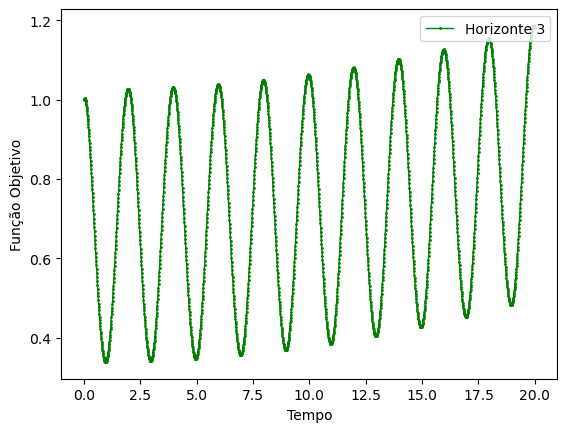

In [16]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0])/abs(valoresFuncaoObjetivo3[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.legend(loc="upper right")
plt.show()

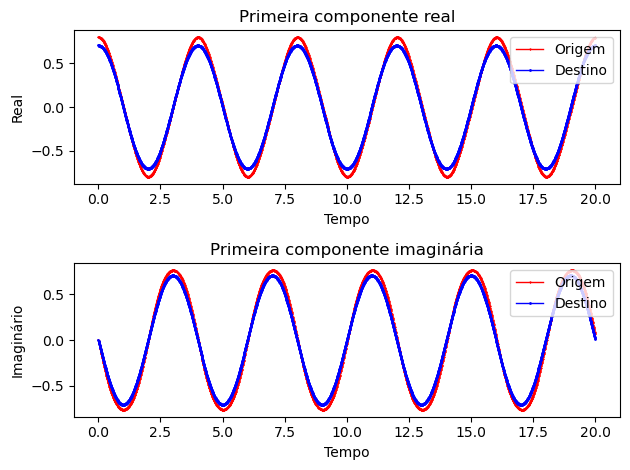

In [17]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()
